# Laboratorio 5
## Data Science
#### Sección 40
Javier Alejandro Ovalle Chiquín, 22103  
José Ángel Morales Farfán, 22689  
Ricardo Josué Morales Contreras, 22289  
Link del repositorio: https://github.com/Saiyan-Javi/Lab5DS

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from wordcloud import WordCloud

In [8]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

In [ ]:
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import classification_report

In [9]:

import re


In [10]:
# ==== Cargar CSV ====
df = pd.read_csv("tweets_texto_normalizados.csv")  
dfor = pd.read_csv("tweets.csv")

#### Analisis exploratorio

Shape del dataset: (7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason this earthquake allah forgive,1
1,4,NaN,NaN,forest fire near ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place being notified o...,1
3,6,NaN,NaN,people receive wildfires evacuation orders cal...,1
4,7,NaN,NaN,just sent this photo from ruby alaska smoke fr...,1



Tipos de datos y nulos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7605 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None
id             0
keyword       61
location    2533
text           8
target         0
dtype: int64
----------------------------

Duplicados por id: 0
Duplicados por texto: 869
----------------------------


Balance de clases (target):
target
0    4342
1    3271
Name: count, dtype: int64
----------------------------


Estadísticas de longitud:
count    7613.000000
mean       60.688428
std        25.345176
min         3.000000
25%        42.000000
50%        61.000000
75%        80.000000
max       134.000000
Name: text_len, dtype: float64
---

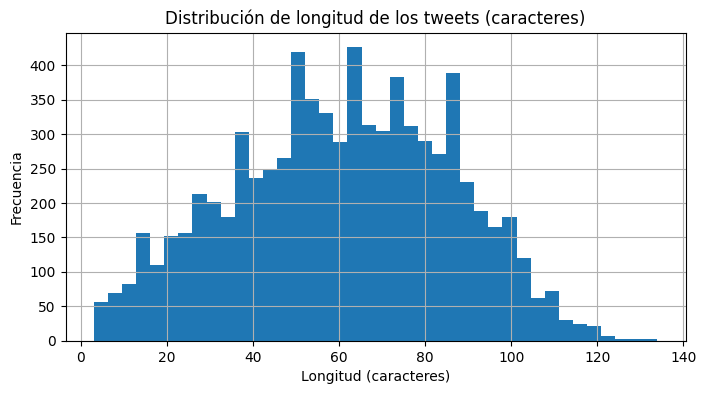

In [11]:
# ==== Vista rápida ====
print("Shape del dataset:", df.shape)
display(df.head())

# ==== Info de columnas ====
print("\nTipos de datos y nulos:")
print(df.info())
print(df.isna().sum())
print("----------------------------\n")

# ==== Revisar duplicados ====
dup_id = df["id"].duplicated().sum()
dup_text = df["text"].duplicated().sum()
print(f"Duplicados por id: {dup_id}")
print(f"Duplicados por texto: {dup_text}")
print("----------------------------\n")

# ==== Balance de clases ====
print("\nBalance de clases (target):")
print(df["target"].value_counts())
print("----------------------------\n")

# ==== Estadísticas de longitud de texto ====
df["text_len"] = df["text"].astype(str).str.len()
print("\nEstadísticas de longitud:")
print(df["text_len"].describe())
print("----------------------------\n")

# Histograma de longitudes
plt.figure(figsize=(8,4))
df["text_len"].hist(bins=40)
plt.title("Distribución de longitud de los tweets (caracteres)")
plt.xlabel("Longitud (caracteres)")
plt.ylabel("Frecuencia")
plt.show()

#### 3) Limpieza del data set

La limpieza del data set se trabajó en el otro archivo de jupiter llamado "Normalizacion Tweets".

In [13]:
df['text_original'] = dfor['text']

In [14]:
print(df.columns)

Index(['id', 'keyword', 'location', 'text', 'target', 'text_len',
       'text_original'],
      dtype='object')


Ahora se va a verificar las keywords, además de crear una columna secundaría de keywords para tener un argumento más robusto a la hora de verificar si el comentario es relacionado con un desastre o no 

In [15]:
# === 4. Preparar lista de keywords ===
keyword_list = df["keyword"].dropna().unique().tolist()
keyword_list = [k.lower().replace("%20", " ") for k in keyword_list]

extra_keywords = ["evacuation", "rescue", "explosion", "emergency", "burning"]
keywords = sorted(set(keyword_list + extra_keywords))

# === 5. Función para buscar keywords ===
def find_keywords(text, keyword_set):
    found = []
    for kw in keyword_set:
        if re.search(r"\b" + re.escape(kw) + r"\b", text):
            found.append(kw)
    return found

# === 6. Crear columnas de keywords ===
df["keywords_found"] = df["text"].apply(lambda x: find_keywords(str(x), keywords))
df["keyword_primary"] = df["keywords_found"].apply(lambda x: x[0] if len(x) > 0 else np.nan)
df["keyword_secondary"] = df["keywords_found"].apply(lambda x: x[1] if len(x) > 1 else np.nan)

# === 7. Ver resultado ===
print(df[["text", "keywords_found", "keyword_primary", "keyword_secondary"]].head(10))


                                                text  \
0         deeds reason this earthquake allah forgive   
1                 forest fire near ronge sask canada   
2  residents asked shelter place being notified o...   
3  people receive wildfires evacuation orders cal...   
4  just sent this photo from ruby alaska smoke fr...   
5  rockyfire update california closed both direct...   
6  flood disaster heavy rain causes flash floodin...   
7                                    hill fire woods   
8  there emergency evacuation happening building ...   
9                    afraid that tornado coming area   

                keywords_found keyword_primary keyword_secondary  
0                 [earthquake]      earthquake               NaN  
1          [fire, forest fire]            fire       forest fire  
2                 [evacuation]      evacuation               NaN  
3                 [evacuation]      evacuation               NaN  
4                      [smoke]           smoke  

Ahora para el modelo preeliminar de selección: 

Para el modelo preliminar de clasificación se propone utilizar un clasificador lineal, específicamente una Regresión Logística o un SVM lineal. Este enfoque resulta adecuado debido a que los mensajes en Twitter son cortos y los n-gramas permiten capturar de manera efectiva términos clave como “fire”, “earthquake” o “evacuation order”, los cuales son relevantes para identificar desastres. Aesta propuesta ofrece una solución práctica y efectiva para establecer una línea base sólida sobre la cual se pueden comparar modelos más avanzados en etapas posteriores del proyecto.

#### 4) Obtenga la frecuencia de las palabras tanto de los tweets de desastres como de los que no.

,token,freq
0,news,137
1,disaster,121
2,california,115
3,suicide,112
4,police,109
5,people,105
6,killed,95
7,hiroshima,92
8,storm,89
9,fires,85


,token,freq
0,body,116
1,video,96
2,people,94
3,love,91
4,know,86
5,time,84
6,emergency,81
7,going,76
8,want,67
9,good,67


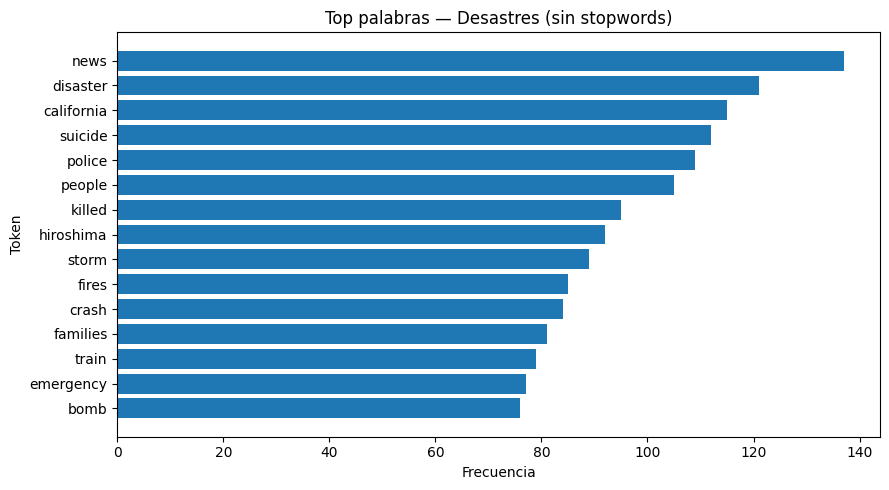

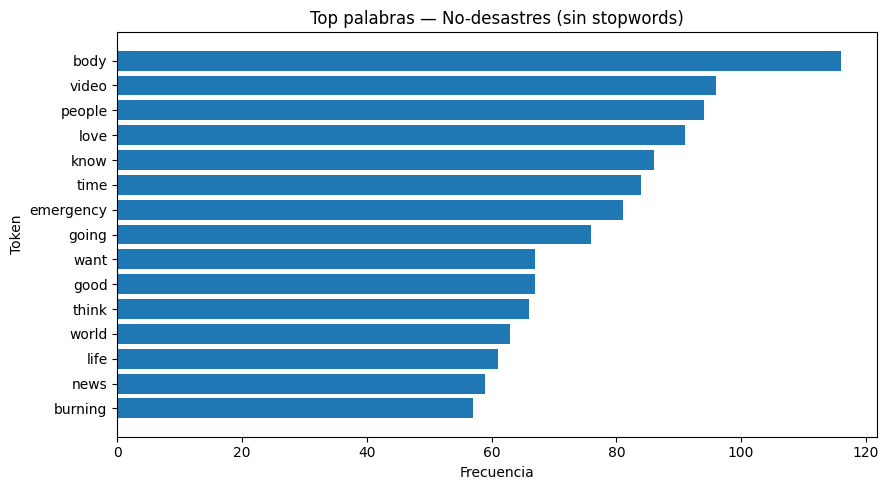

In [16]:

# --- Stopwords (inglés + dominio) ---
custom_stop = {
    # conectores/comunes
    "im","ive","u","ur","rt","via","amp","us","one","two","get","got","still","today","yesterday",
    # pronombres/auxiliares muy poco informativos
    "this","that","these","those","with","from","have","has","had","been","being","was","were","will","would",
    "they","their","there","here","your","you","we","our","just","like","more","when","what","over","into",
}
STOP = set(ENGLISH_STOP_WORDS) | custom_stop

# Tokenización segura
df["text"] = df["text"].fillna("").astype(str)
df["tokens"] = df["text"].str.split()
df["tokens"] = df["tokens"].apply(lambda toks: [t for t in toks if t and t not in STOP])

# Separar tokens por clase
tokens_disaster = [t for row in df.loc[df["target"]==1, "tokens"].dropna() for t in row]
tokens_nondisaster = [t for row in df.loc[df["target"]==0, "tokens"].dropna() for t in row]

# Top-N
TOP_N = 25
freq_disaster = pd.DataFrame(Counter(tokens_disaster).most_common(TOP_N), columns=["token","freq"])
freq_nondisaster = pd.DataFrame(Counter(tokens_nondisaster).most_common(TOP_N), columns=["token","freq"])

display(freq_disaster)
display(freq_nondisaster)

# Gráficos
def plot_top_tokens(df_freq, title, top=15):
    sub = df_freq.head(top)
    plt.figure(figsize=(9,5))
    plt.barh(sub["token"][::-1], sub["freq"][::-1])
    plt.title(title)
    plt.xlabel("Frecuencia")
    plt.ylabel("Token")
    plt.tight_layout()
    plt.show()

plot_top_tokens(freq_disaster, "Top palabras — Desastres (sin stopwords)", top=15)
plot_top_tokens(freq_nondisaster, "Top palabras — No-desastres (sin stopwords)", top=15)



In [17]:
STOP_LIST = list(STOP)  # usar las mismas stopwords

def top_ngrams(texts, ngram_range=(1,1), top_k=20, min_df=2):
    texts = [x for x in texts if isinstance(x, str) and x.strip()]
    if not texts:
        return pd.DataFrame(columns=["ngram","freq"])
    vec = CountVectorizer(ngram_range=ngram_range, min_df=min_df, stop_words=STOP_LIST)
    X = vec.fit_transform(texts)
    counts = X.sum(axis=0).A1
    vocab = vec.get_feature_names_out()
    freq = pd.DataFrame({"ngram": vocab, "freq": counts})
    return freq.sort_values("freq", ascending=False).head(top_k).reset_index(drop=True)

texts_all = df["text"].tolist()
texts_d   = df.loc[df["target"]==1, "text"].tolist()
texts_nd  = df.loc[df["target"]==0, "text"].tolist()

uni_global = top_ngrams(texts_all, (1,1), 20)
bi_global  = top_ngrams(texts_all, (2,2), 20)
tri_global = top_ngrams(texts_all, (3,3), 20)

print("Top 20 unigrams (global)"); display(uni_global)
print("Top 20 bigrams (global)");  display(bi_global)
print("Top 20 trigrams (global)"); display(tri_global)

bi_d  = top_ngrams(texts_d, (2,2), 20)
bi_nd = top_ngrams(texts_nd, (2,2), 20)

print("Top 20 bigrams — Desastres");     display(bi_d)
print("Top 20 bigrams — No-desastres");  display(bi_nd)


Top 20 unigrams (global)


,ngram,freq
0,people,199
1,news,196
2,video,165
3,emergency,158
4,disaster,158
5,police,143
6,body,131
7,burning,121
8,storm,121
9,california,121


Top 20 bigrams (global)


,ngram,freq
0,burning buildings,60
1,suicide bomber,59
2,liked video,41
3,northern california,41
4,cross body,40
5,suicide bombing,36
6,california wildfire,34
7,natural disaster,32
8,mass murder,32
9,mass murderer,31


Top 20 trigrams (global)


,ngram,freq
0,suicide bomber detonated,30
1,northern california wildfire,29
2,16yr suicide bomber,28
3,bomber detonated bomb,28
4,homes razed northern,28
5,latest homes razed,28
6,razed northern california,27
7,affected fatal outbreak,26
8,families affected fatal,26
9,wreckage conclusively confirmed,25


Top 20 bigrams — Desastres


,ngram,freq
0,suicide bomber,59
1,northern california,41
2,burning buildings,37
3,suicide bombing,35
4,california wildfire,34
5,bomber detonated,30
6,confirmed mh370,29
7,homes razed,29
8,latest homes,28
9,detonated bomb,28


Top 20 bigrams — No-desastres


,ngram,freq
0,cross body,39
1,liked video,34
2,body bagging,24
3,burning buildings,23
4,body bags,23
5,reddit quarantine,21
6,quarantine offensive,21
7,offensive content,20
8,content policy,20
9,loud bang,19


Al analizar las frecuencias de palabras separando los tweets por clase, se observa una clara diferencia en el vocabulario.

En los tweets de desastres (target=1) destacan términos directamente relacionados con emergencias: news, disaster, california, suicide, police, people, killed, hiroshima, storm, fires, crash, families, train, emergency, bomb. Estas palabras reflejan sucesos como incendios, atentados, tormentas, accidentes y víctimas, lo que confirma que son útiles para identificar mensajes vinculados con eventos catastróficos.

En contraste, los tweets de no-desastres (target=0) muestran un léxico cotidiano y genérico: body, video, people, love, know, time, going, want, good, world, life. Aunque aparecen algunos términos similares (ej. emergency, news), su contexto es distinto y no necesariamente implica un desastre.

El análisis de n-gramas refuerza estas diferencias. En los bigramas de desastres aparecen combinaciones clave como suicide bomber, northern california, california wildfire, burning buildings, bomber detonated, que aportan contexto más específico que un unigram aislado. En cambio, en los bigramas de no-desastres predominan frases poco relacionadas con emergencias, como cross body, liked video, content policy. Los trigramas, aunque menos frecuentes, capturan narrativas completas de desastres, por ejemplo suicide bomber detonated o northern california wildfire.

#### 5) Análisis exploratorio de los datos para entenderlos mejor

#### 5.1 
Palabra que se repite más en cada categoría.

In [18]:
# Tokens ya procesados en la columna 'tokens'
tokens_disaster = [t for row in df.loc[df["target"]==1, "tokens"].dropna() for t in row]
tokens_nondisaster = [t for row in df.loc[df["target"]==0, "tokens"].dropna() for t in row]

# Palabra más común en cada clase
top_disaster = Counter(tokens_disaster).most_common(1)[0]
top_nondisaster = Counter(tokens_nondisaster).most_common(1)[0]

print("Palabra más repetida en tweets de desastres:", top_disaster)
print("Palabra más repetida en tweets no-desastres:", top_nondisaster)


Palabra más repetida en tweets de desastres: ('news', 137)
Palabra más repetida en tweets no-desastres: ('body', 116)


Realización de una nube de palabras para visualizar las que aparezcan con más frecuencia:

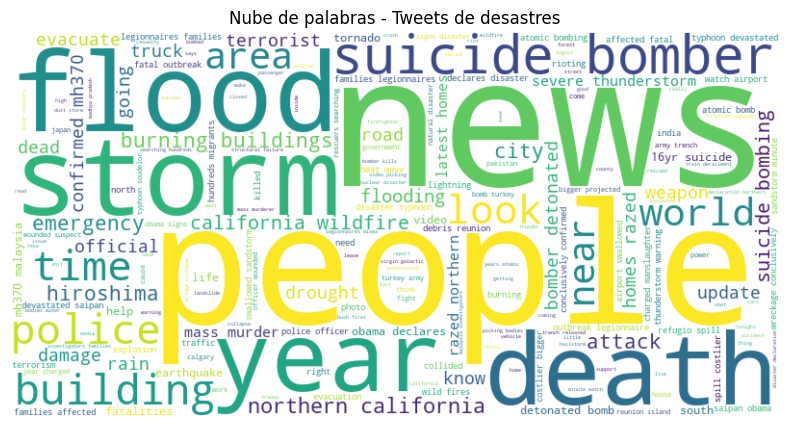

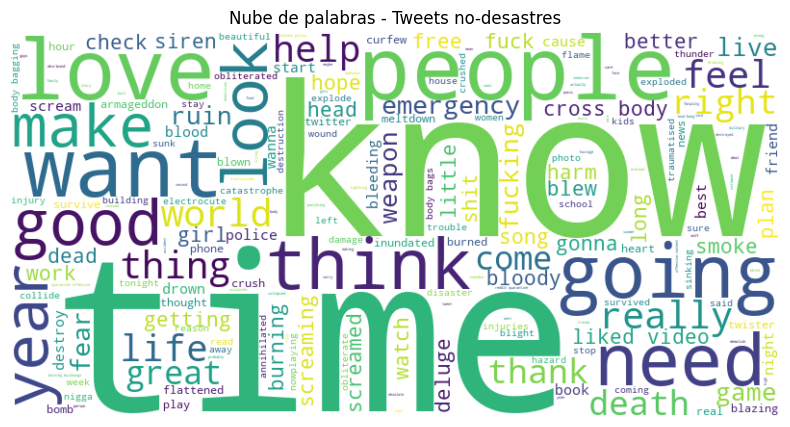

In [19]:
# Unir tokens por clase
text_disaster = " ".join(tokens_disaster)
text_nondisaster = " ".join(tokens_nondisaster)

# Nube para desastres
wc_disaster = WordCloud(width=800, height=400, background_color="white").generate(text_disaster)
plt.figure(figsize=(10,5))
plt.imshow(wc_disaster, interpolation="bilinear")
plt.axis("off")
plt.title("Nube de palabras - Tweets de desastres")
plt.show()

# Nube para no-desastres
wc_nondisaster = WordCloud(width=800, height=400, background_color="white").generate(text_nondisaster)
plt.figure(figsize=(10,5))
plt.imshow(wc_nondisaster, interpolation="bilinear")
plt.axis("off")
plt.title("Nube de palabras - Tweets no-desastres")
plt.show()


Las nubes permiten observar de manera visual la importancia relativa de cada término:

- En desastres, resaltan palabras como storm, flood, death, suicide, police, bomb, hiroshima, california wildfire, lo cual refleja vocabulario propio de eventos catastróficos.

- En no-desastres, destacan know, love, time, want, people, good, que corresponden a lenguaje más cotidiano y menos técnico.

Histograma con las palabras más repetidas:

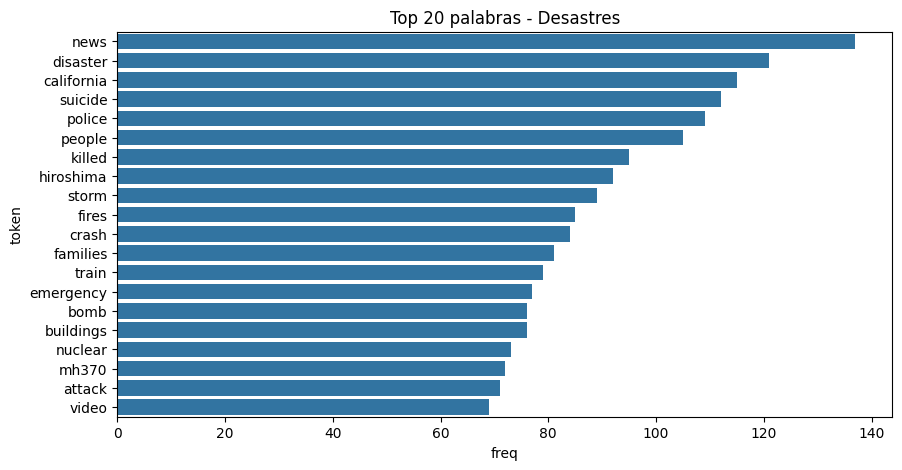

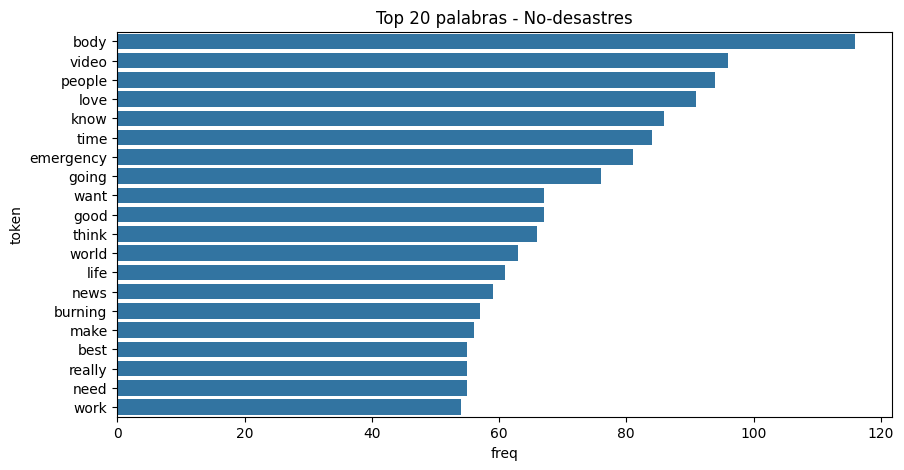

In [20]:
# Top 20 palabras en cada categoría
freq_disaster = Counter(tokens_disaster).most_common(20)
freq_nondisaster = Counter(tokens_nondisaster).most_common(20)

df_freq_disaster = pd.DataFrame(freq_disaster, columns=["token","freq"])
df_freq_nondisaster = pd.DataFrame(freq_nondisaster, columns=["token","freq"])

# Gráfico desastres
plt.figure(figsize=(10,5))
sns.barplot(y="token", x="freq", data=df_freq_disaster)
plt.title("Top 20 palabras - Desastres")
plt.show()

# Gráfico no-desastres
plt.figure(figsize=(10,5))
sns.barplot(y="token", x="freq", data=df_freq_nondisaster)
plt.title("Top 20 palabras - No-desastres")
plt.show()


Los histogramas confirman las diferencias:

- En desastres predominan términos específicos como disaster, suicide, storm, crash, families, emergency.

- En no-desastres se repiten expresiones de interacción social y opinión como video, love, know, going, good, work.

Esto evidencia que las clases no solo difieren en magnitud de frecuencia, sino también en el tipo de vocabulario utilizado.

Palabras con presencia en ambas categorías:

In [21]:
# Palabras que aparecen en las dos clases
set_disaster = set(tokens_disaster)
set_nondisaster = set(tokens_nondisaster)

common_words = set_disaster & set_nondisaster
print("Número de palabras comunes entre ambas categorías:", len(common_words))
print("Ejemplos de palabras comunes:", list(common_words)[:30])


Número de palabras comunes entre ambas categorías: 3307
Ejemplos de palabras comunes: ['york', 'dying', 'cree', 'satellite', 'film', 'injuries', 'casualties', 'activated', 'bounds', 'gabon', 'debt', 'chicago', 'abortion', 'collision', 'denial', '1979', 'asked', 'water', 'announcement', 'later', 'electro', 'users', 'winds', 'legacy', 'blown', 'european', 'marines', 'ireland', 'beneath', 'claims']


Existen 3,307 palabras presentes en ambas clases, entre ellas ejemplos como photography, demons, drones, cheap, beach.
Esto muestra que una fracción importante del vocabulario es compartido, pero la diferencia clave está en el contexto: palabras como body o emergency pueden aparecer tanto en mensajes de desastre como en mensajes irrelevantes, lo cual refuerza la necesidad de modelos que consideren combinaciones (bigramas, trigramas) y contexto semántico.

#### 6) Modelos de clasificación

Para determinar si un tweet se refiere a un desastre real o no, se plantean varios modelos de clasificación supervisada.  

**Modelos a probar:**
- **Regresión Logística:** baseline lineal, eficiente y fácilmente interpretable.  
- **SVM lineal (LinearSVC):** robusto para texto, maneja bien clases desbalanceadas.  
- **Naive Bayes Multinomial:** rápido, simple y muy utilizado en clasificación de texto.  
- **Random Forest:** modelo de ensamble que puede capturar interacciones no lineales.  

**Abordaje del contexto:**  
El contexto en este problema se aborda principalmente con **n-gramas** (para capturar relaciones de palabras consecutivas) y con la ponderación TF-IDF (para dar más importancia a términos distintivos). Esto ayuda a diferenciar palabras ambiguas como *body* o *emergency* según sus combinaciones. Además, se puede evaluar más adelante el uso de embeddings (Word2Vec, BERT), pero en esta etapa inicial los n-gramas son suficientes para un baseline sólido.


In [22]:
# === 1. Separar datos ===
X = df["text"]   # columna de texto ya normalizado
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# === 2. Definir modelos a probar ===
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, class_weight="balanced"),
    "Linear SVM": LinearSVC(class_weight="balanced"),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42)
}

# === 3. Vectorizador TF-IDF (uni + bigramas) ===
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=3, max_features=20000)

# === 4. Evaluar con validación cruzada ===
for name, model in models.items():
    pipe = Pipeline([
        ("tfidf", vectorizer),
        ("clf", model)
    ])
    scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring="f1")
    print(f"{name}: F1 promedio = {np.mean(scores):.3f} (+/- {np.std(scores):.3f})")


Logistic Regression: F1 promedio = 0.740 (+/- 0.006)
Linear SVM: F1 promedio = 0.718 (+/- 0.017)
Naive Bayes: F1 promedio = 0.719 (+/- 0.011)
Random Forest: F1 promedio = 0.720 (+/- 0.018)


Entre los modelos evaluados, la Regresión Logística obtuvo el mejor desempeño, alcanzando un F1 promedio de 0.74, superando a SVM, Naive Bayes y Random Forest que se mantuvieron alrededor de 0.72. Además, presentó la menor variabilidad en los resultados de validación cruzada, lo que indica mayor estabilidad. Por estas razones, se selecciona la Regresión Logística como el modelo preliminar más adecuado para la clasificación de tweets en desastres y no-desastres.

Ahora procederemos a entrenar específicamente ese modelo además de ver métricas más específicas.

=== Reporte de clasificación (Test Set) ===
              precision    recall  f1-score   support

           0      0.821     0.830     0.825       869
           1      0.771     0.760     0.765       654

    accuracy                          0.800      1523
   macro avg      0.796     0.795     0.795      1523
weighted avg      0.799     0.800     0.800      1523



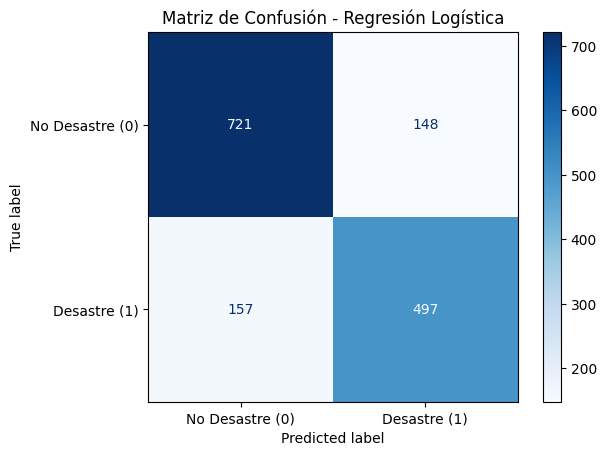

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# === 1. Definir pipeline con TF-IDF + Regresión Logística ===
best_model = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=3, max_features=20000)),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=42))
])

# === 2. Entrenar en el conjunto de train ===
best_model.fit(X_train, y_train)

# === 3. Evaluar en el conjunto de test ===
y_pred = best_model.predict(X_test)

# Reporte de clasificación
print("=== Reporte de clasificación (Test Set) ===")
print(classification_report(y_test, y_pred, digits=3))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Desastre (0)", "Desastre (1)"])
disp.plot(cmap="Blues")
plt.title("Matriz de Confusión - Regresión Logística")
plt.show()


El modelo de Regresión Logística alcanzó un accuracy del 80% en el conjunto de prueba, con un F1 de 0.825 para la clase “no desastre” y 0.765 para la clase “desastre”. Esto muestra un rendimiento equilibrado entre ambas categorías. La matriz de confusión indica que de 869 tweets no relacionados con desastres, 721 fueron clasificados correctamente y 148 se confundieron como desastres. En la clase de desastres, de 654 casos, 497 se predijeron bien y 157 se clasificaron erróneamente como no-desastres.

En general, el modelo logra distinguir de manera efectiva entre tweets de desastres y no-desastres, aunque presenta una ligera tendencia a confundir algunos desastres como no-desastres, lo que reduce el recall de la clase 1 (0.760). Aun así, estos resultados confirman que la Regresión Logística es un modelo sólido para este problema y constituye una base confiable sobre la cual se pueden probar enfoques más avanzados (como embeddings o transformers).

#### 7) Elabore una función en la que el usuario ingrese un tweet y el sistema lo clasifique en desastre o no.

Primero crearemos una función de limpieza, ya que se entrenó el modelo con los datos limpios.

In [24]:
import re, html

def clean_text_for_inference(text: str) -> str:
    """Limpieza coherente con el dataset normalizado."""
    text = str(text)
    text = html.unescape(text)
    text = text.lower()
    text = re.sub(r"<.*?>", " ", text)                 # HTML
    text = re.sub(r"http\S+|www\.\S+", " ", text)      # URLs
    text = re.sub(r"@\w+", " ", text)                  # menciones
    text = text.replace("#", " ")                      # deja palabra del hashtag
    text = re.sub(r"[^\x00-\x7F]+", " ", text)         # no-ASCII
    text = re.sub(r"\b911\b", " nineoneone_token ", text)  # preservar 911
    text = re.sub(r"\d+", " ", text)                   # números
    text = re.sub(r"nineoneone_token", " 911 ", text)
    text = re.sub(r"[^\w\s]", " ", text)               # puntuación
    text = re.sub(r"\s+", " ", text).strip()
    return text


Aquí creamos la función que predice si el tweet sera de desastres (1) o No (0)

In [25]:
import numpy as np

LABELS = {0: "No Desastre (0)", 1: "Desastre (1)"}

def classify_tweet(tweet_text: str, apply_clean: bool = True):
    """
    Clasifica un tweet como desastre/no-desastre usando el modelo entrenado.
    - apply_clean=True: aplica la misma limpieza que el dataset normalizado.
    """
    # Verificación básica
    try:
        best_model
    except NameError:
        raise RuntimeError(
            "El modelo 'best_model' no está definido. Entrénalo antes (celda de punto 6)."
        )

    text = clean_text_for_inference(tweet_text) if apply_clean else str(tweet_text)
    pred = best_model.predict([text])[0]

    # Si el clasificador tiene predict_proba, devolvemos la prob. de clase 1
    prob = None
    if hasattr(best_model.named_steps["clf"], "predict_proba"):
        prob = float(best_model.predict_proba([text])[0][1])

    resultado = {
        "input": tweet_text,
        "procesado": text,
        "prediccion": int(pred),
        "etiqueta": LABELS[int(pred)],
        "prob_desastre": prob,  # puede ser None si el modelo no soporta proba
    }
    return resultado

# Ejemplos de uso:
ej1 = "Breaking: Huge wildfire near the city, people evacuated."
ej2 = "Love this song! Great vibes for Monday."
print(classify_tweet(ej1))
print(classify_tweet(ej2))


{'input': 'Breaking: Huge wildfire near the city, people evacuated.', 'procesado': 'breaking huge wildfire near the city people evacuated', 'prediccion': 1, 'etiqueta': 'Desastre (1)', 'prob_desastre': 0.9574786506879608}
{'input': 'Love this song! Great vibes for Monday.', 'procesado': 'love this song great vibes for monday', 'prediccion': 0, 'etiqueta': 'No Desastre (0)', 'prob_desastre': 0.08354713252781255}


Crearemos una función la cual permite que el usuario ingrese un tweet e imprima el resultado.

In [26]:
# Función que pide al usuario un tweet y lo clasifica
def classify_from_input():
    tweet = input("Escribe un tweet para clasificar: ")
    resultado = classify_tweet(tweet, apply_clean=True)
    print(f"\n➡️ '{resultado['input']}' → {resultado['etiqueta']}  (prob. desastre={resultado['prob_desastre']:.3f})")

# Uso:
classify_from_input()



➡️ 'Excited for the football game tonight, go team!' → No Desastre (0)  (prob. desastre=0.244)


#### 8) Análisis de sentimiento con AFINN

Usamos el léxico **AFINN** (puntajes -5 a +5). Calculamos un `afinn_score` por tweet y lo mapeamos a
**positivo / negativo / neutral** con umbrales. Mantenemos el criterio acordado:
si un tweet **solo reporta** (factual, sin adjetivos/emoción), puede marcarse como **neutral**
(opción “neutralización factual” activable).



**AFINN** es un léxico de sentimiento creado por Finn Årup Nielsen. Contiene miles de palabras en inglés, cada una asociada a un puntaje entre -5 (muy negativo) y +5 (muy positivo). El análisis consiste en sumar los puntajes de las palabras presentes en un texto; si el resultado es positivo, se interpreta como un sentimiento positivo; si es negativo, como negativo; y si está cercano a cero, como neutral.  



In [27]:
from afinn import Afinn

afn = Afinn()  # inglés, puntajes -5..+5

# Cargar el dataset ya normalizado (texto limpio en 'text')
df["text"] = df["text"].fillna("").astype(str)


In [28]:
# Términos de dominio (desastres) típicamente factuales; puedes ampliarlos
DISASTER_TERMS = {
    "earthquake","wildfire","fire","flood","storm","hurricane","tornado","tsunami",
    "landslide","eruption","volcano","explosion","bomb","blast","crash","derailment",
    "evacuation","evacuate","rescue","aftershock","drought","heatwave","typhoon"
}

# tokenizador simple (palabras alfanuméricas)
TOKEN_RE = re.compile(r"[a-zA-Z0-9_]+")

def label_from_afinn(text: str, pos_thresh=0.5, neg_thresh=-0.5,
                     neutralize_factual=True, strong_subj=2):
    """
    - Calcula score AFINN del texto.
    - Mapea a etiqueta según umbrales.
    - Si neutralize_factual=True: si el texto solo tiene vocabulario de desastre (factual)
      y carece de términos con alta carga subjetiva (|score| >= strong_subj), lo marca como 'neutral'.
    """
    text = str(text)
    score = afn.score(text)

    # Etiqueta por umbral
    if score > pos_thresh:
        label = "positivo"
    elif score < neg_thresh:
        label = "negativo"
    else:
        label = "neutral"

    if neutralize_factual:
        toks = [t.lower() for t in TOKEN_RE.findall(text)]
        # puntajes por token vía AFINN
        tok_scores = [afn.score(t) for t in toks]
        # tokens con puntaje != 0 (los que AFINN reconoce)
        marked_tokens = [(t, s) for t, s in zip(toks, tok_scores) if s != 0]

        if marked_tokens:
            # ¿todos los tokens marcados son términos de desastre?
            all_domain = all(t in DISASTER_TERMS for t, _ in marked_tokens)
            # ¿existen términos claramente subjetivos? (|score| >= strong_subj)
            has_strong_subjective = any(abs(s) >= strong_subj for _, s in marked_tokens)

            if all_domain and not has_strong_subjective:
                # reporte factual puro → neutralizamos
                label = "neutral"

    return score, label


In [29]:
df["afinn_score"], df["afinn_label"] = zip(*df["text"].apply(label_from_afinn))

# Vista rápida
df[["text","afinn_score","afinn_label"]].head(12)


,text,afinn_score,afinn_label
0,deeds reason this earthquake allah forgive,1.0,positivo
1,forest fire near ronge sask canada,-2.0,negativo
2,residents asked shelter place being notified o...,-1.0,neutral
3,people receive wildfires evacuation orders cal...,-1.0,neutral
4,just sent this photo from ruby alaska smoke fr...,0.0,neutral
5,rockyfire update california closed both direct...,-2.0,negativo
6,flood disaster heavy rain causes flash floodin...,-2.0,negativo
7,hill fire woods,-2.0,negativo
8,there emergency evacuation happening building ...,-3.0,negativo
9,afraid that tornado coming area,-2.0,negativo


- Tweets con palabras cargadas negativamente (“disaster”, “afraid”, “died”, “heat wave”) se clasificaron como negativos, con puntajes entre -1 y -3.

- Tweets con agradecimientos o expresiones positivas (“allah forgive”, “haha…wait second lol”) aparecen como positivos con puntajes entre +1 y +3.

- Otros que son reportes factuales, sin carga subjetiva clara (“wildfires evacuation orders”, “photo from ruby alaska smoke”), fueron marcados como neutrales.

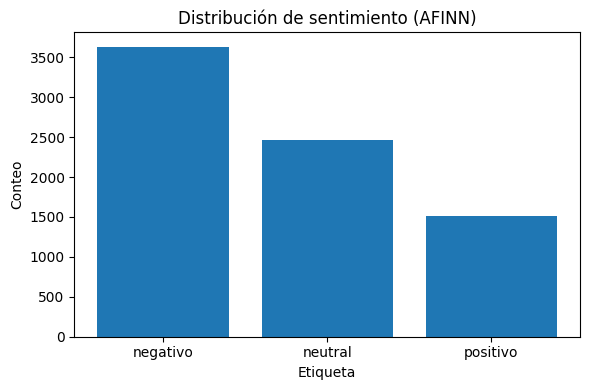

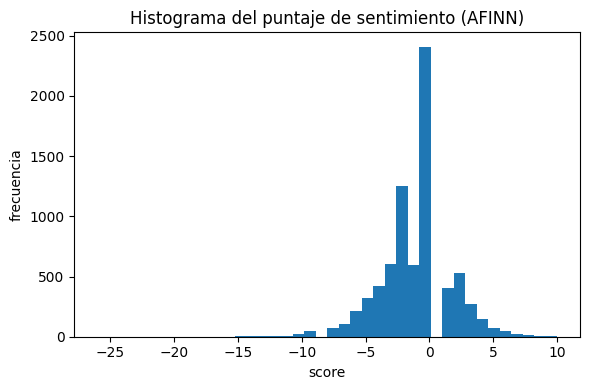

In [30]:
# Conteo de etiquetas
counts = df["afinn_label"].value_counts().reindex(["negativo","neutral","positivo"]).fillna(0)

plt.figure(figsize=(6,4))
plt.bar(counts.index.astype(str), counts.values)
plt.title("Distribución de sentimiento (AFINN)")
plt.xlabel("Etiqueta")
plt.ylabel("Conteo")
plt.tight_layout()
plt.show()

# Histograma del score AFINN
plt.figure(figsize=(6,4))
plt.hist(df["afinn_score"], bins=40)
plt.title("Histograma del puntaje de sentimiento (AFINN)")
plt.xlabel("score")
plt.ylabel("frecuencia")
plt.tight_layout()
plt.show()


Sobre la distribución:

- La mayor parte de los tweets están en la categoría negativa, lo cual tiene sentido porque el dataset describe desastres y situaciones de riesgo.

- Una proporción relevante quedó como neutral, sobre todo en mensajes que son reportes de hechos.

- Los positivos son minoría, pero aparecen cuando hay agradecimientos, apoyo o expresiones de alivio.

Sobre el histograma de scores:

- La distribución está sesgada hacia valores negativos (muchos puntajes entre -5 y -2).

- Hay un pico fuerte en 0, correspondiente a los neutrales.

- También hay valores positivos pero en menor cantidad.

#### 9) Identificar sentimientos en los tweets

#### 9.1) ¿Cuáles son los 10 tweets más negativos? y su categoría

In [32]:
# Top 10 más negativos
top_neg = df.sort_values("afinn_score").head(10)[["text","afinn_score","afinn_label","target"]]
print("=== 10 tweets más negativos ===")
display(top_neg)


=== 10 tweets más negativos ===


,text,afinn_score,afinn_label,target
7472,wreck wreck wreck wreck wreck wreck wreck wrec...,-26.0,negativo,0
6980,just stop fucking saying whole nother just sou...,-19.0,negativo,0
5430,these fucking police touch these fuck niggas f...,-17.0,negativo,0
3597,year charged with manslaughter toddler report ...,-15.0,negativo,1
3600,year charged with manslaughter toddler report ...,-15.0,negativo,1
3610,year charged with manslaughter toddler report ...,-15.0,negativo,1
3603,year charged with manslaughter toddler report ...,-15.0,negativo,1
3604,year charged with manslaughter toddler report ...,-15.0,negativo,1
3613,year charged with manslaughter toddler report ...,-15.0,negativo,1
3589,year charged with manslaughter toddler report ...,-15.0,negativo,1


#### 9.2) ¿Cuáles son los 10 tweets más positivos? y su categoría

In [33]:
# Top 10 más positivos
top_pos = df.sort_values("afinn_score", ascending=False).head(10)[["text","afinn_score","afinn_label","target"]]
print("=== 10 tweets más positivos ===")
display(top_pos)


=== 10 tweets más positivos ===


,text,afinn_score,afinn_label,target
6560,yeah survived seasons movies hope good there hope,10.0,positivo,0
6292,today storm will pass tomorrow light greet wit...,10.0,positivo,1
6992,check want twister tickets experience shania c...,10.0,positivo,0
1909,disillusioned lead character check happy lucky...,10.0,positivo,0
5006,pakistan supreme court military courts civilia...,10.0,positivo,0
6020,better learn derivative formula seismic rather...,9.0,positivo,0
132,aftershock back school kick great want thank e...,9.0,positivo,0
5656,coastal german shepherd rescue shared link ecs...,9.0,positivo,0
2238,meditationbymsg 45600 method meditation deluge...,8.0,positivo,0
6140,super sweet beautiful,8.0,positivo,0


#### 9.3) Comparar entre categorías

In [35]:
# Promedio de scores por categoría
avg_scores = df.groupby("target")["afinn_score"].mean()

# Distribución de etiquetas por categoría
label_dist = df.groupby(["target","afinn_label"]).size().unstack(fill_value=0)

print("=== Puntaje promedio de AFINN por categoría ===")
print(avg_scores)
print("\n=== Distribución de etiquetas de sentimiento por categoría ===")
print(label_dist)

# Interpretación rápida
if avg_scores[1] < avg_scores[0]:
    print("\nEn promedio, los tweets de desastres reales (target=1) son más negativos.")
else:
    print("\nEn promedio, los tweets de no-desastres (target=0) son más negativos.")


=== Puntaje promedio de AFINN por categoría ===
target
0   -0.498618
1   -1.799144
Name: afinn_score, dtype: float64

=== Distribución de etiquetas de sentimiento por categoría ===
afinn_label  negativo  neutral  positivo
target                                  
0                1744     1484      1114
1                1886      983       402

En promedio, los tweets de desastres reales (target=1) son más negativos.


#### 10) Inclusión de la variable de negatividad 

In [36]:
# Crear la variable 'negativity'
df["negativity"] = df["afinn_score"].apply(lambda x: max(0, -x))

df[["text","afinn_score","negativity"]].head(12)


,text,afinn_score,negativity
0,deeds reason this earthquake allah forgive,1.0,0.0
1,forest fire near ronge sask canada,-2.0,2.0
2,residents asked shelter place being notified o...,-1.0,1.0
3,people receive wildfires evacuation orders cal...,-1.0,1.0
4,just sent this photo from ruby alaska smoke fr...,0.0,0.0
5,rockyfire update california closed both direct...,-2.0,2.0
6,flood disaster heavy rain causes flash floodin...,-2.0,2.0
7,hill fire woods,-2.0,2.0
8,there emergency evacuation happening building ...,-3.0,3.0
9,afraid that tornado coming area,-2.0,2.0


Ahora vamos a entrenar el modelo con la nueva variable

In [ ]:
# Separar train/test
X_train, X_test, y_train, y_test = train_test_split(df["text"], df["target"], test_size=0.2, random_state=42)

# === Transformador custom para extraer la columna 'negativity' ===
class NegativityExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        # Devuelve la columna 'negativity' como array 2D
        return df.loc[X.index, ["negativity"]].values

# Vectorizador TF-IDF
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=3, max_features=20000)

# Union de TF-IDF + Negativity
features = FeatureUnion([
    ("tfidf", tfidf),
    ("negativity", NegativityExtractor())
])

# Pipeline
from sklearn.pipeline import Pipeline
clf_with_neg = Pipeline([
    ("features", features),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=42))
])

# Entrenamiento
clf_with_neg.fit(X_train, y_train)

# Evaluación
y_pred = clf_with_neg.predict(X_test)
print("=== Reporte de clasificación con 'negativity' incluida ===")
print(classification_report(y_test, y_pred, digits=3))


=== Reporte de clasificación con 'negativity' incluida ===
              precision    recall  f1-score   support

           0      0.811     0.799     0.805       874
           1      0.734     0.749     0.741       649

    accuracy                          0.777      1523
   macro avg      0.772     0.774     0.773      1523
weighted avg      0.778     0.777     0.778      1523



Se creó la variable `negativity`, que representa la magnitud del puntaje negativo de AFINN para cada tweet. Posteriormente se entrenó nuevamente el modelo de clasificación combinando **TF-IDF** con esta nueva característica.

Los resultados mostraron que el rendimiento **no mejoró**, sino que disminuyó ligeramente:
- Accuracy pasó de 0.800 a 0.777.
- El F1-score para la clase de desastres (1) cayó de 0.765 a 0.741.
- El macro promedio de F1 bajó de 0.795 a 0.773.

Esto indica que la información de negatividad ya estaba suficientemente capturada por los vectores de texto TF-IDF, por lo que añadir la variable explícita no aportó valor adicional. En algunos casos, incluso puede introducir redundancia o ruido.  

En conclusión, la inclusión de `negativity` **no mejoró el modelo** en este caso, lo cual resalta la importancia de evaluar empíricamente cada nueva variable antes de incorporarla de forma definitiva.
